In [16]:
import pandas as pd
import numpy as np
import torch as th
import paradime
import paradime.dr
import paradime.loss
import paradime.routines
import paradime.utils
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import torchvision
from itertools import combinations
import mplcursors

In [2]:
# Download dataset
covertype = sklearn.datasets.fetch_covtype()

_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

indices = list(th.utils.data.WeightedRandomSampler(weights, 7000))

raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

label_to_name = {
    1: "Spruce/fir",
    2: "Lodgepole pine",
    3: "Ponderosa pine",
    4: "Cottonwood/willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}

labels = covertype.target[indices]

same_label = (np.outer(labels, np.ones_like(labels))
    - np.outer(np.ones_like(labels), labels) == 0).astype(float)

In [3]:
#np.arange or torch

class twoNAMHybrid(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, output_dim=2, num_layers=1):
        super(twoNAMHybrid, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Create submodules for each combination of input feature and output dimension
        self.submodules = th.nn.ModuleDict()
        for i in range(input_dim):
            for j in range(output_dim):
                key = f"{i}_{j}"
                self.submodules[key] = self.create_submodule(num_layers, hidden_dim)

    def create_submodule(self, num_layers, hidden_dim):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, 1))
        return submodule

    def forward(self, x):
        outputs = th.zeros(x.shape[0], self.output_dim)
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                key = f"{i}_{j}"
                outputs[:, j] += self.submodules[key](x[:, i].unsqueeze(1)).squeeze()
        return outputs
    
    def embed(self, x):
        return self.forward(x)

    def feature_importances(self, x):
        # Set the model to evaluation mode
        self.eval()

        # Initialize gradients
        x.requires_grad = True

        # Forward pass
        output = self.forward(x)

        # Calculate gradients
        output.backward(gradient=th.ones_like(output))

        # Calculate feature importances as the absolute gradients
        importances = th.abs(x.grad)

        return importances
    
    def get_feature_maps(self, resolution=100):
        output_1D = th.zeros(self.input_dim, resolution, self.output_dim)
        for i in range(self.input_dim):
            for j in range(resolution):
                # Change sampling from 0-1 to -1-1
                input_value = th.tensor([[-1 + 2*j / (resolution - 1)]]).float()
                for d in range(self.output_dim):
                    key = f"{i}_{d}"
                    output_1D[i, j, d] = self.submodules[key](input_value)
        return output_1D.detach().numpy()

In [4]:
tsne_global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=200, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)


tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)


embeddings = []
  
new_losses = {
   
    "embedding": paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div,
        global_relation_key="tsne",
    )
}

In [5]:

super_tsne = paradime.dr.ParametricDR(
    model=twoNAMHybrid(
        input_dim=10, hidden_dim=100, num_classes=7, output_dim=2,
    ),
    global_relations={
        "tsne": tsne_global_rel,
        "same_label": paradime.relations.Precomputed(same_label),
    },
    batch_relations=tsne_batch_rel,
    losses=new_losses,
    use_cuda=False,
    verbose=True,
)

###########

#super_tsne.add_training_phase(tsne_init)
super_tsne.add_training_phase(
    name="embedding",
    loss_keys=["embedding"],
    loss_weights=[1],
    sampling="negative_edge",
    neg_sampling_rate=1,
    edge_rel_key="same_label",
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)
super_tsne.train(data)

embeddings.append(super_tsne.apply(data))

2023-10-26 17:08:23,085: Initializing training dataset.
2023-10-26 17:08:23,085: Computing global relations 'tsne'.
2023-10-26 17:08:23,086: Indexing nearest neighbors.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2023-10-26 17:08:37,543: Calculating probabilities.
2023-10-26 17:08:38,406: Computing global relations 'same_label'.
2023-10-26 17:08:38,824: Beginning training phase 'embedding'.
2023-10-26 17:08:39,768: Loss after epoch 0: 0.01036615646444261
2023-10-26 17:08:41,603: Loss after epoch 2: 0.00910067290533334
2023-10-26 17:08:43,428: Loss after epoch 4: 0.008815087610855699
2023-10-26 17:08:45,204: Loss after epoch 6: 0.00850077613722533
2023-10-26 17:08:46,970: Loss after epoch 8: 0.008373869932256639
2023-10-26 17:08:48,826: Loss after epoch 10: 0.0083907728549093
2023-10-26 17:08:50,596: Loss after epoch 12: 0.00837991142179817
2023-10-26 17:08:52,359: Loss after epoch 14: 0.00825006328523159
2023-10-26 17:08:54,125: Loss after epoch 16: 0.008316989755257964
2023-10-26 17:08:55,893: Loss after epoch 18: 0.008256490691564977
2023-10-26 17:08:57,661: Loss after epoch 20: 0.008235169458203018
2023-10-26 17:08:59,419: Loss after epoch 22: 0.00823301577474922
2023-10-26 17:09:01,182: Los

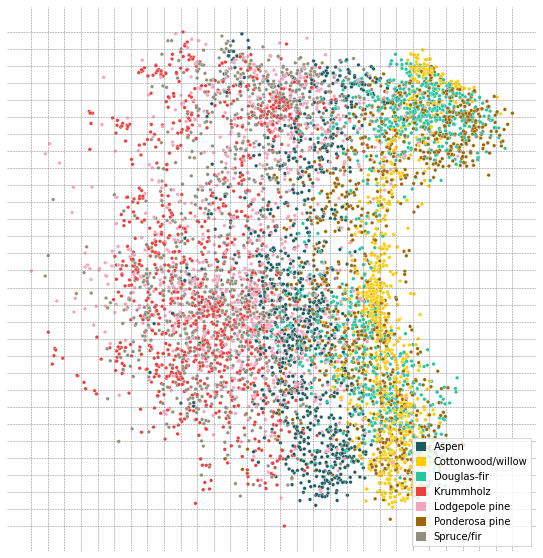

In [27]:
# Create the scatterplot and get the axes object
ax = paradime.utils.plotting.scatterplot(
    embeddings[0],  # Use the embeddings we computed
    labels=[label_to_name[i] for i in covertype.target[indices]],
)

# Extract x and y values for determining grid extents
x = embeddings[0][:, 0].cpu().numpy()
y = embeddings[0][:, 1].cpu().numpy()

# Calculate the grid edges
grid_size = 30  # or whatever grid resolution you desire
xedges = np.linspace(x.min(), x.max(), grid_size)
yedges = np.linspace(y.min(), y.max(), grid_size)

# Add grid
for xedge in xedges:
    ax.axvline(x=xedge, color='gray', linestyle='--', linewidth=0.5)
for yedge in yedges:
    ax.axhline(y=yedge, color='gray', linestyle='--', linewidth=0.5)

plt.show()


In [8]:
print(embeddings[0].shape)

torch.Size([7000, 2])


Note: Die Aussage ist basically: Nachdem wir dann noch die y Achse normalisiert haben, können wir besser ablesen. Und evtl machen wir noch die Range von -3 zu 3 damit wir wirklich alle samples abedecken, weil zurzeit the data standardisiert ist mit einem mean von 0 und sdv von 1, also centered um 0 herum aber sie sind nicht strictly in der -1 zu 1 Range. Dann können wir an den Achsen ablesen: Welchen Wert hat x bzw y angenommen wenn dieses feature größer oder kleiner wurde? "Je größer der Wert wurde (zb. Länge eines Blattes), desto negativer wurde unser y, also wurde dieser punkt nun an diesem (x,y) Coordinate geplact in unserem embedding. 

In [9]:
feature_maps = super_tsne.model.get_feature_maps()
#invertieren - achsen vertauscht 


In [11]:
# Let's say you want a 10x10 grid
grid_size = 10
x = embeddings[0][:, 0].cpu().numpy()
y = embeddings[0][:, 1].cpu().numpy()

# Create a histogram to segregate points into a grid
hist, xedges, yedges = np.histogram2d(x, y, bins=grid_size)

In [12]:
# This function returns the points in a particular bin
def get_points_in_bin(x, y, xedges, yedges, i, j):
    x_mask = (x > xedges[i]) & (x <= xedges[i+1])
    y_mask = (y > yedges[j]) & (y <= yedges[j+1])
    return x[x_mask & y_mask], y[x_mask & y_mask]

feature_maps = super_tsne.model.get_feature_maps()

# Compute feature contributions for a point
def compute_feature_contributions(point, feature_maps):
    contributions = np.zeros(10)
    for i in range(10):
        contributions[i] = np.sum(point * feature_maps[i])
    return contributions

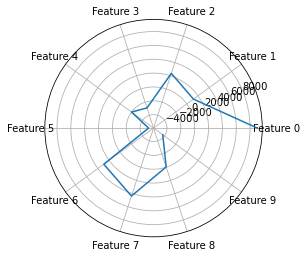

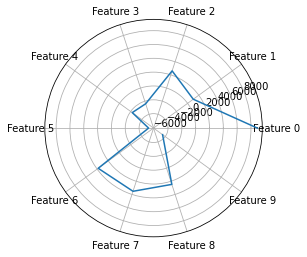

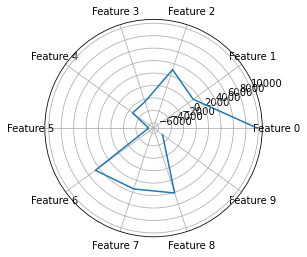

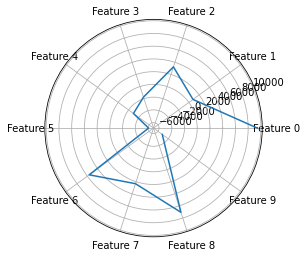

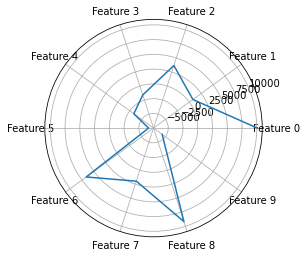

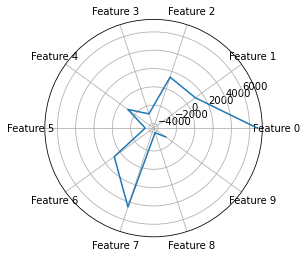

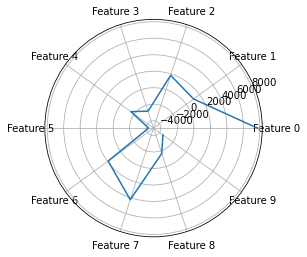

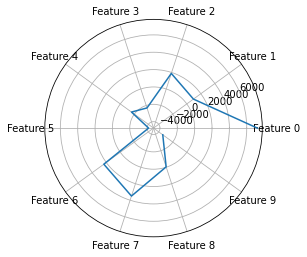

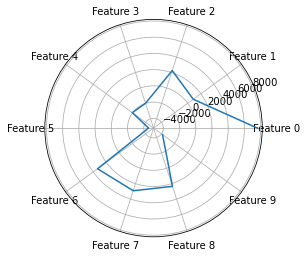

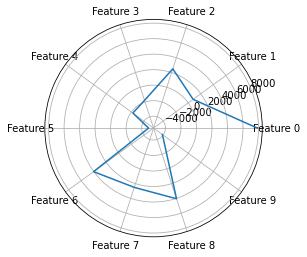

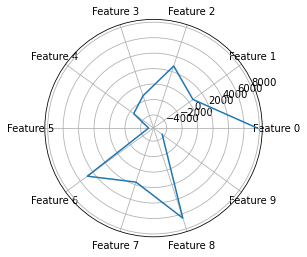

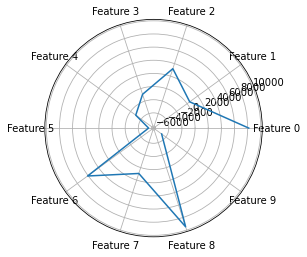

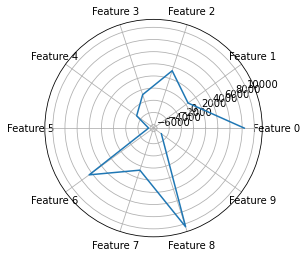

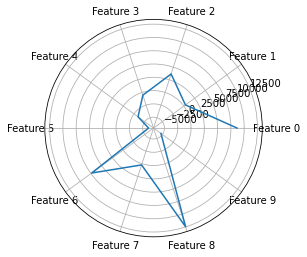

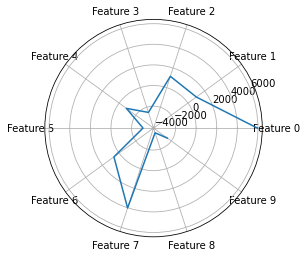

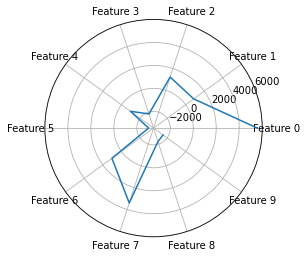

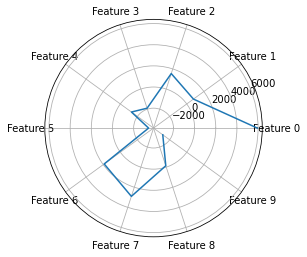

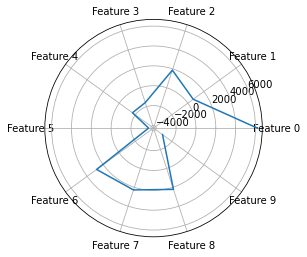

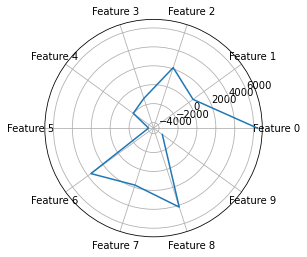

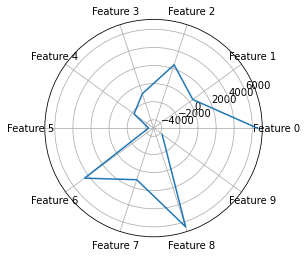

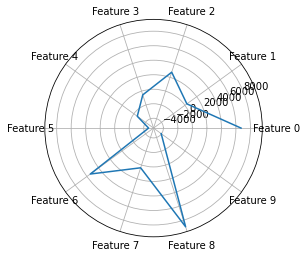

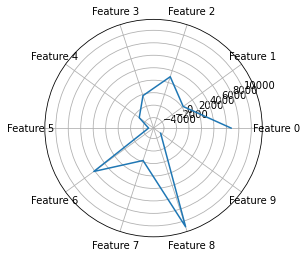

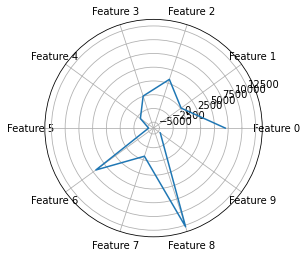

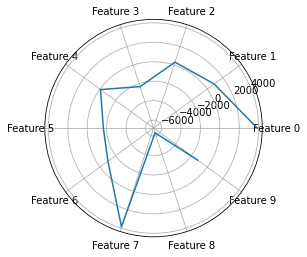

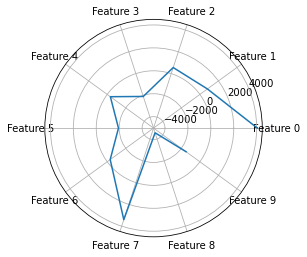

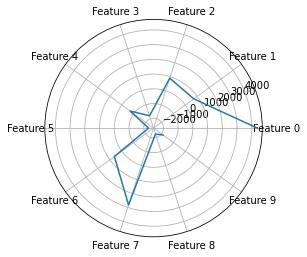

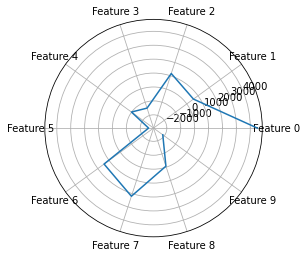

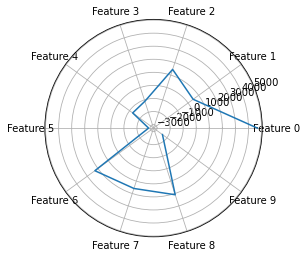

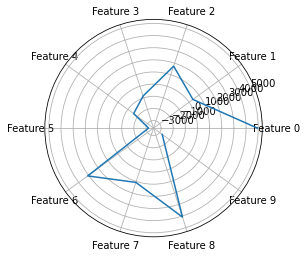

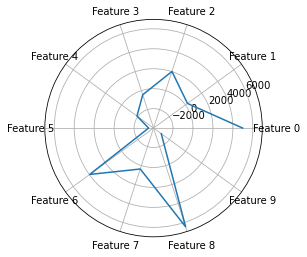

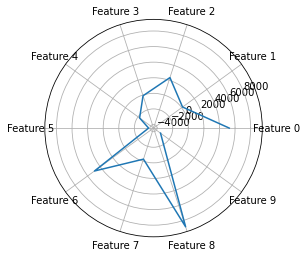

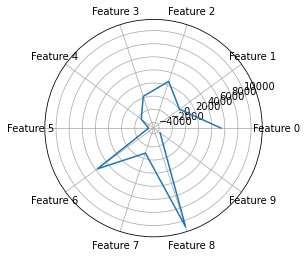

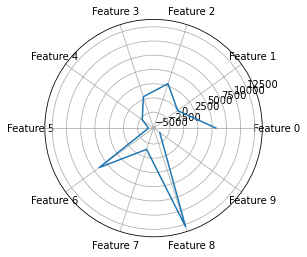

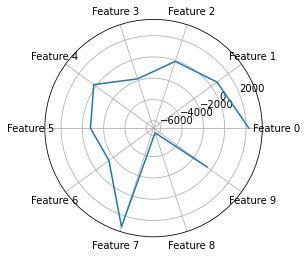

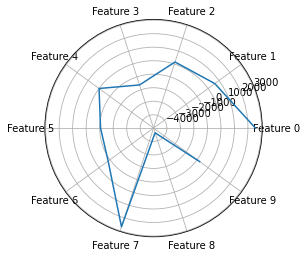

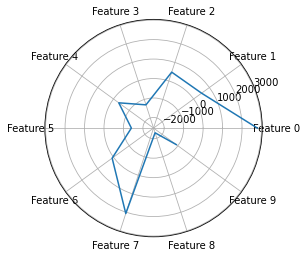

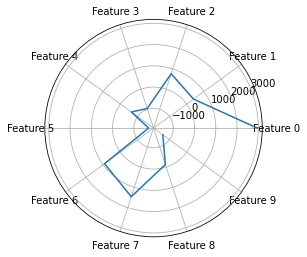

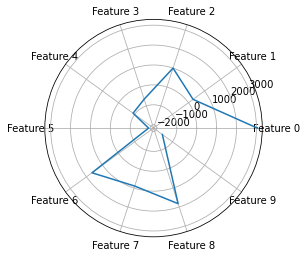

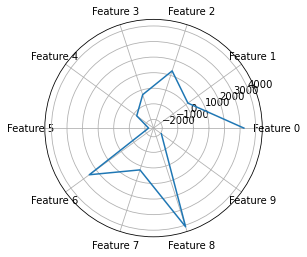

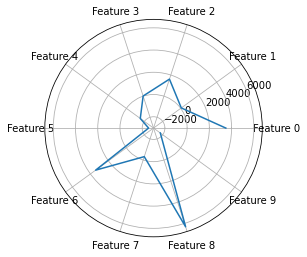

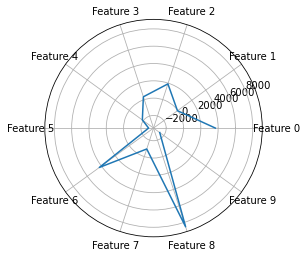

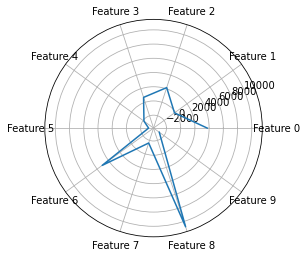

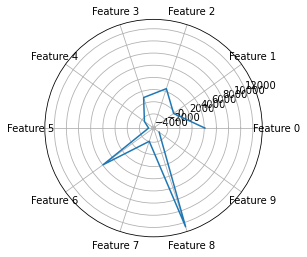

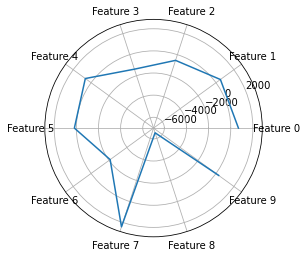

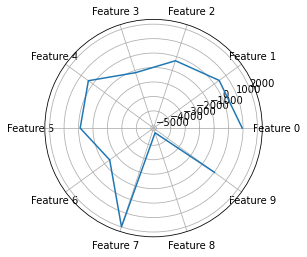

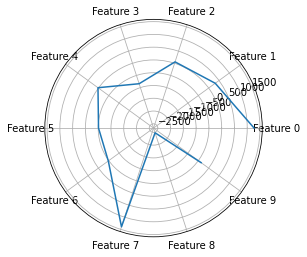

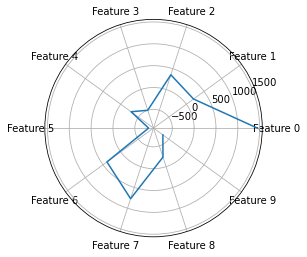

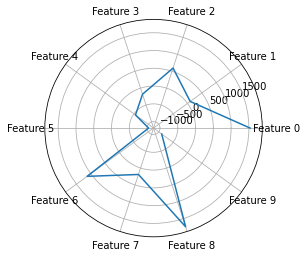

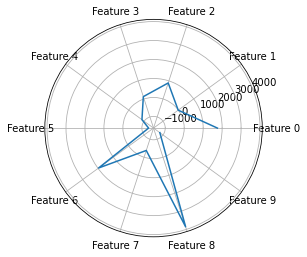

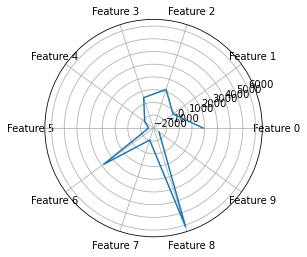

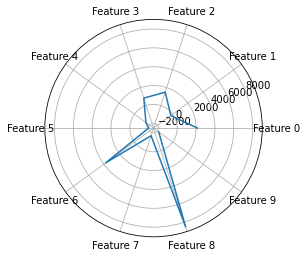

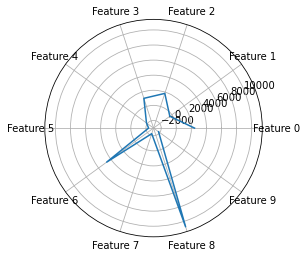

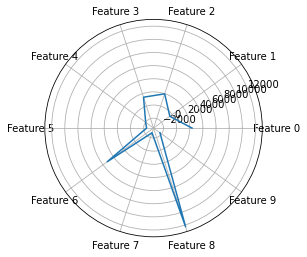

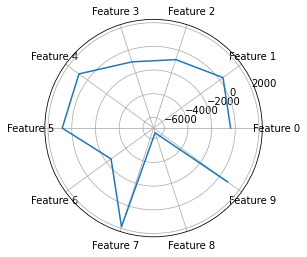

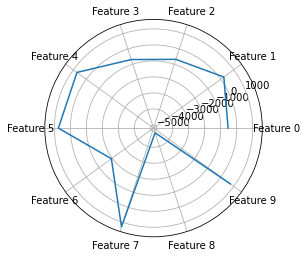

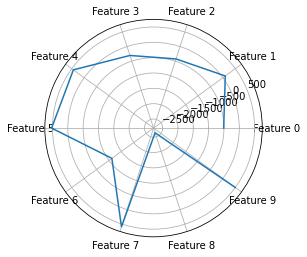

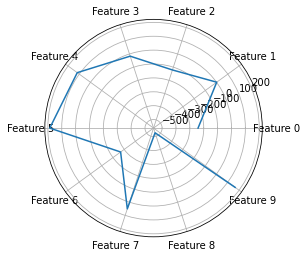

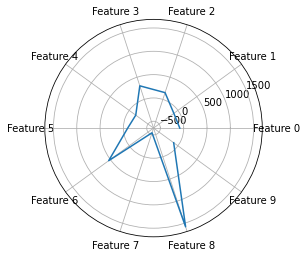

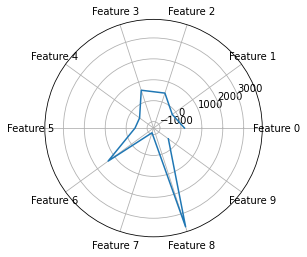

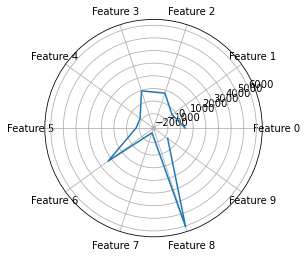

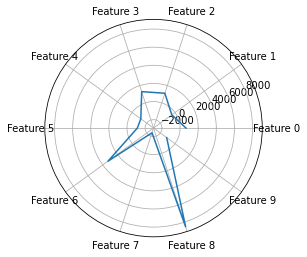

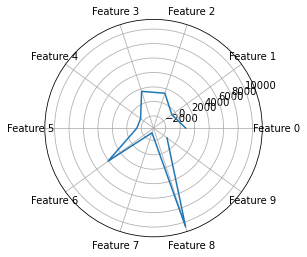

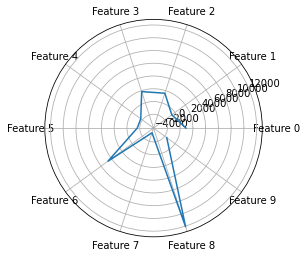

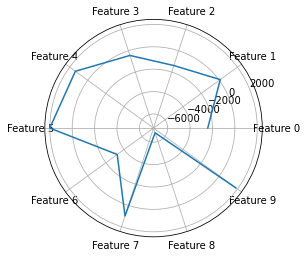

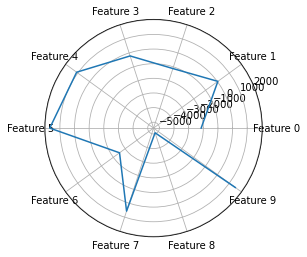

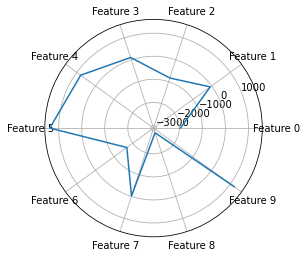

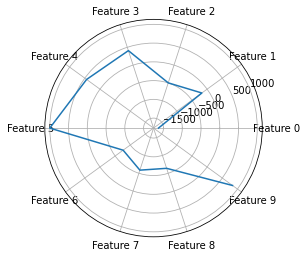

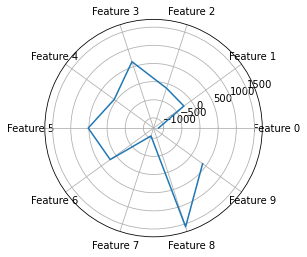

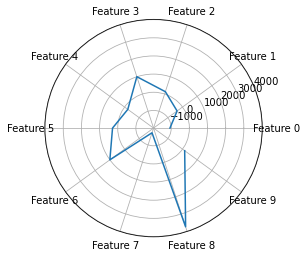

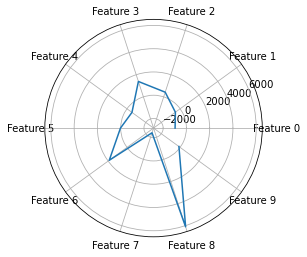

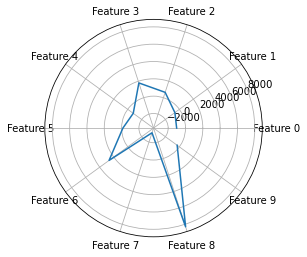

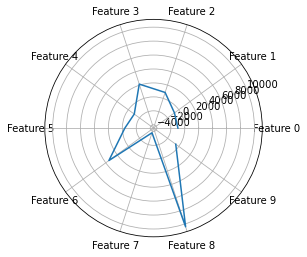

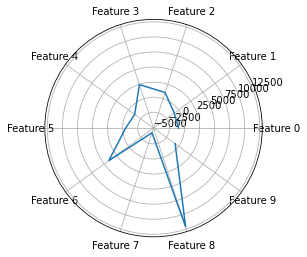

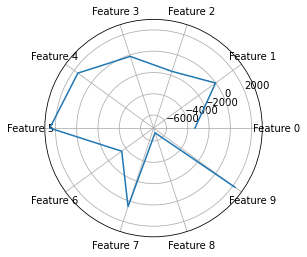

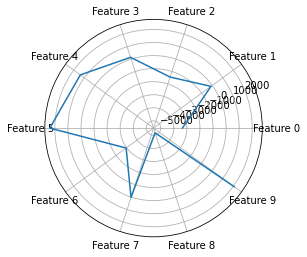

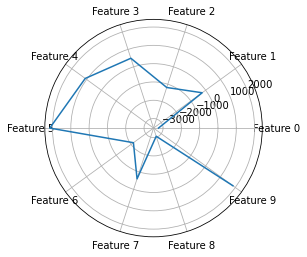

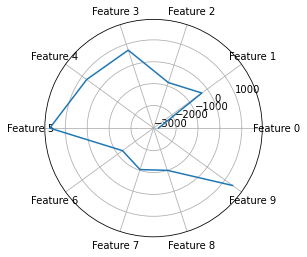

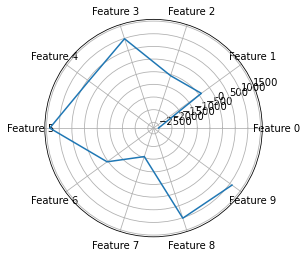

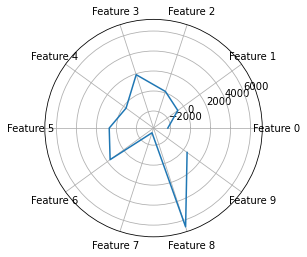

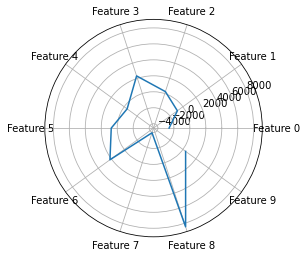

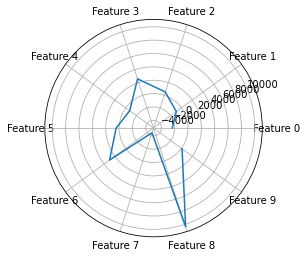

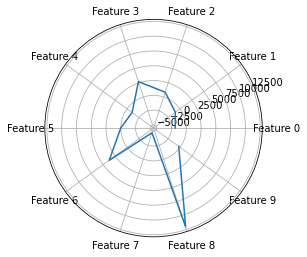

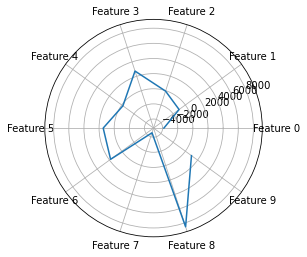

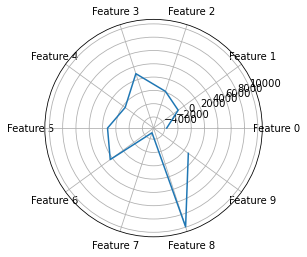

In [13]:

def plot_star_glyph(contributions):
    theta = np.linspace(0.0, 2 * np.pi, len(contributions), endpoint=False)
    radii = contributions

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta, radii)

    feature_names = ["Feature " + str(i) for i in range(10)]
    ax.set_xticks(theta)
    ax.set_xticklabels(feature_names)
    plt.show()

# For each bin, plot the star glyph
for i in range(grid_size):
    for j in range(grid_size):
        x_bin, y_bin = get_points_in_bin(x, y, xedges, yedges, i, j)
        if len(x_bin) == 0:  # skip empty bins
            continue

        contributions = np.zeros(10)
        for xi, yi in zip(x_bin, y_bin):
            contributions += compute_feature_contributions([xi, yi], feature_maps)
        contributions /= len(x_bin)  # get average contributions

        plot_star_glyph(contributions)

In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create scatter plot with grid
fig = make_subplots(rows=1, cols=2, shared_xaxes=True,
                    shared_yaxes=True,
                    column_widths=[0.7, 0.3],
                    subplot_titles=('Scatter Plot', 'Star Glyph'),
                    specs=[[{'type': 'scatter'}, {'type': 'polar'}]])

scatter = go.Scattergl(
    x=x, y=y,
    mode='markers',
    marker=dict(color=labels, colorscale='Viridis', size=5),
    showlegend=False
)

fig.add_trace(scatter, row=1, col=1)

# Add grid lines
for xedge in xedges:
    fig.add_shape(go.layout.Shape(type="line", x0=xedge, x1=xedge, y0=y.min(), y1=y.max()),
                  row=1, col=1)
for yedge in yedges:
    fig.add_shape(go.layout.Shape(type="line", x0=x.min(), x1=x.max(), y0=yedge, y1=yedge),
                  row=1, col=1)

# Create dummy star glyph plot
theta = np.linspace(0.0, 2 * np.pi, 10, endpoint=False)
radii = np.zeros(10)
polar = go.Scatterpolar(
    r=radii, theta=theta,
    mode='lines+markers',
    marker=dict(size=5),
    showlegend=False
)
fig.add_trace(polar, row=1, col=2)

# Define callback function to update star glyph plot
def update_star_glyph(trace, points, selector):
    if len(points.point_inds) == 0:
        return
    ind = points.point_inds[0]
    x_val = x[ind]
    y_val = y[ind]

    i = np.digitize(x_val, xedges) - 1
    j = np.digitize(y_val, yedges) - 1

    x_bin, y_bin = get_points_in_bin(x, y, xedges, yedges, i, j)
    contributions = np.zeros(10)
    for xi, yi in zip(x_bin, y_bin):
        contributions += compute_feature_contributions([xi, yi], feature_maps)
    contributions /= len(x_bin)  # get average contributions

    fig.data[-1].r = contributions

scatter.on_hover(update_star_glyph)

# Show plot
fig.show()


In [30]:
import plotly.express as px
import numpy as np
import pandas as pd

# Extract the embeddings and create a DataFrame
x = embeddings[0][:, 0].cpu().numpy()
y = embeddings[0][:, 1].cpu().numpy()

df = pd.DataFrame({
    'x': x,
    'y': y,
    'label': [label_to_name[i] for i in covertype.target[indices]],
    'sample_id_original': indices,  # Original sample ID from the full dataset
    'sample_id_subsample': list(range(len(indices)))  # Local ID for the subsampled data
})

# Create the scatter plot
fig = px.scatter(df, x='x', y='y', 
                 color='label', 
                 hover_data=['x', 'y', 'sample_id_original', 'sample_id_subsample'], 
                 labels={'label': 'Tree Type'},
                 title='Embeddings Visualization')

# Add gridlines
grid_size = 30
xedges = np.linspace(x.min(), x.max(), grid_size)
yedges = np.linspace(y.min(), y.max(), grid_size)

for xedge in xedges:
    fig.add_shape(type="line", x0=xedge, y0=y.min(), x1=xedge, y1=y.max(), line=dict(color="gray", width=0.5, dash="dot"))
for yedge in yedges:
    fig.add_shape(type="line", x0=x.min(), y0=yedge, x1=x.max(), y1=yedge, line=dict(color="gray", width=0.5, dash="dot"))

# Show the plot
fig.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def feature_contributions(sample_id, data, model):
    x = data[sample_id].unsqueeze(0).float() # Ensuring the data is in float32 format
    feature_maps = model.get_feature_maps()

    contributions = []

    for j in range(2):
        for i in range(model.input_dim):
            key = f"{i}_{j}"
            avg_contrib = feature_maps[i, :, j].mean()
            actual_contrib = model.submodules[key](x[0, i].unsqueeze(0).unsqueeze(0))
            contributions.append((actual_contrib - avg_contrib).item())

    # Split contributions for x and y dimensions
    half = len(contributions) // 2
    x_contributions = contributions[:half]
    y_contributions = contributions[half:]

    return x_contributions, y_contributions

def plot_star_glyph(contributions, title):
    # Define the number of variables (i.e., features)
    num_vars = len(contributions)

    # Calculate the angle for each axis in the plot
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    # Append the start value to each contribution list for it to be closed
    contributions += contributions[:1]

    # Set up the polar subplot
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Set the first axis on top
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(range(1, num_vars + 1))
    
    # Draw the outline of our data
    ax.plot(angles, contributions, linewidth=2, linestyle='solid')
    ax.fill(angles, contributions, alpha=0.4)
    
    # Title
    plt.title(title)

    plt.show()

def visualize_star_glyph(sample_id, data, model):
    x_contributions, y_contributions = feature_contributions(sample_id, data, model)

    # Normalize contributions for better visualization
    max_val = max(max(x_contributions), max(y_contributions))
    x_contributions = [c / max_val for c in x_contributions]
    y_contributions = [c / max_val for c in y_contributions]

    # Plot
    plot_star_glyph(x_contributions, "X Dimension Contributions")
    plot_star_glyph(y_contributions, "Y Dimension Contributions")


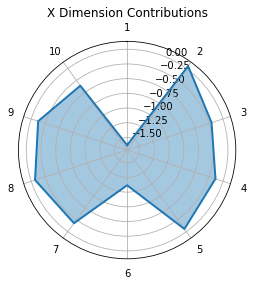

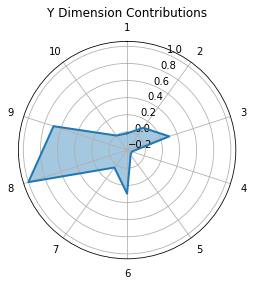

In [41]:
# Sample function call
sample_id = 1205
visualize_star_glyph(sample_id, th.tensor(data), super_tsne.model)